In [1]:
# Trick to import local code:
import sys
sys.path = ['/home/mp/michelj/src/sensorsio/src'] + sys.path

In [2]:
import rasterio as rio
import numpy as np
from matplotlib import pyplot
from sensorsio import sentinel2, utils

# Creating a dataset

Constructor of ```sentinel2.Sentinel2``` class reads the path to the ***Sentinel2 L2A*** product:

In [3]:
dataset = sentinel2.Sentinel2('/datalake/S2-L2A-THEIA/31TDH/2019/05/31/SENTINEL2B_20190531-105916-927_L2A_T31TDH_C_V2-2/')

Printing the returned objects gives basic information on the product:

In [4]:
print(dataset)

SENTINEL2B, 2019-05-31 00:00:00, 31TDH


Among the object attributes, one can find information on acquisition date as a ```datetime.datetime``` object, acquisition year, and day of year:

In [5]:
print(f"date: {dataset.date}, year: {dataset.year}, day of year: {dataset.day_of_year}")

date: 2019-05-31 00:00:00, year: 2019, day of year: 151


One can also read the satellite id, the MGRS tile id and the corresponding coordinate reference system:

In [6]:
print(f"Satellite: {dataset.satellite.value}, MGRS tile: dataset.tile, CRS: {dataset.crs}")

Satellite: SENTINEL2B, MGRS tile: dataset.tile, CRS: EPSG:32631


Last, the object also contains the geographic bounds expressed in the given CRS.

In [7]:
print(f"Product bounds: {dataset.bounds}")

Product bounds: BoundingBox(left=399960.0, bottom=4690200.0, right=509760.0, top=4800000.0)


# Basic reading

## Reading to numpy

### Selecting bands

```sentinel2.Sentinel2.GROUP_10M``` is a convenient variable to select all 10m bands:

In [8]:
sentinel2.Sentinel2.GROUP_10M

[<Band.B2: 'B2'>, <Band.B3: 'B3'>, <Band.B4: 'B4'>, <Band.B8: 'B8'>]

In a similar way, ```sentinel2.Sentinel2.GROUP_20M``` and ```sentinel2.Sentinel2.GROUP_60M``` exist:

In [9]:
sentinel2.Sentinel2.GROUP_20M

[<Band.B5: 'B5'>,
 <Band.B6: 'B6'>,
 <Band.B7: 'B7'>,
 <Band.B8A: 'B8A'>,
 <Band.B11: 'B11'>,
 <Band.B12: 'B12'>]

In [10]:
sentinel2.Sentinel2.GROUP_60M

[<Band.B9: 'B9'>, <Band.B10: 'B10'>]

One can of course make her own selection of bands:

In [11]:
my_bands = [sentinel2.Sentinel2.B2, sentinel2.Sentinel2.B8A]

### A first read

In the following we will use the ```sentinel2.Sentinel2.GROUP_10M``` to read all 10m bands to a numpy array:

In [12]:
bands, masks, xcoords, ycoords, crs = dataset.read_as_numpy(sentinel2.Sentinel2.GROUP_10M)

The first returned value is a ```numpy.ndarray``` with shape ```[bands, height, width]``` containing pixels reflectances:

In [13]:
bands.shape

(4, 10980, 10980)

The second returned value is a ```numpy.ndarray``` with shape ```[masks, height, width]``` containing masks values (by default, the 4 masks are read):

In [14]:
masks.shape

(4, 10980, 10980)

3rd and 4th returned values are the row and col coordinates expressed in the given crs:

In [15]:
xcoords, ycoords

(array([399960., 399970., 399980., ..., 509730., 509740., 509750.]),
 array([4800000., 4799990., 4799980., ..., 4690230., 4690220., 4690210.]))

Last returned value is the crs as a string:

In [16]:
crs

CRS.from_epsg(32631)

By default, pixels values are scaled to $[0,1]$, and missing values are set to ```numpy.nan``` (hence the use of ```nanmin``` and ```nanmax``` in the following):

In [17]:
np.nanmin(bands, axis=(1,2)), np.nanmax(bands, axis=(1,2))

(array([0., 0., 0., 0.], dtype=float32),
 array([1.4091, 1.3115, 1.246 , 1.1927], dtype=float32))

### Displaying the image

The ```utils``` module provides a convenient function that will prepare the array for display with ```matplotlib```. The ```bands ``` argument indicates which slice of the first dimension to map to the red, green and blue channels. ```dmin``` and ```dmax``` arguments allows to select the displayed range for each band. 

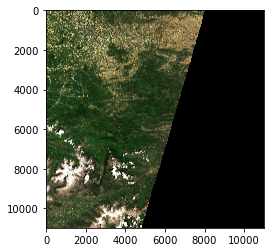

In [18]:
arr_rgb, dmin, dmax = utils.rgb_render(bands, bands=[2,1,0], 
                                 dmin=np.array([0., 0., 0.]), 
                                 dmax=np.array([0.2,0.2,0.2]))
pyplot.imshow(arr_rgb)

## Reading to xarray Dataset

The ```xarray``` library provides a nice decoration of ```numpy``` arrays for even more abstraction:

In [19]:
xrds = dataset.read_as_xarray(sentinel2.Sentinel2.GROUP_10M)

In [20]:
print(xrds)

<xarray.Dataset>
Dimensions:  (t: 1, x: 10980, y: 10980)
Coordinates:
  * t        (t) datetime64[ns] 2019-05-31
  * x        (x) float64 4e+05 4e+05 4e+05 ... 5.097e+05 5.097e+05 5.098e+05
  * y        (y) float64 4.8e+06 4.8e+06 4.8e+06 ... 4.69e+06 4.69e+06 4.69e+06
Data variables:
    B2       (t, y, x) float32 0.0364 0.0378 0.0406 0.0393 ... nan nan nan nan
    SAT      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    CLM      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    EDG      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1 1
    MG2      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    B3       (t, y, x) float32 0.0652 0.068 0.0742 0.0752 ... nan nan nan nan
    B4       (t, y, x) float32 0.063 0.0712 0.0735 0.0728 ... nan nan nan nan
    B8       (t, y, x) float32 0.2343 0.2349 0.2369 0.2456 ... nan nan nan nan
Attributes:
    tile:     31TDH
    type:     FRE
    crs:      EPSG:32631


The created datasets contains several variables, with the requested bands and masks:

In [21]:
xrds.data_vars

Data variables:
    B2       (t, y, x) float32 0.0364 0.0378 0.0406 0.0393 ... nan nan nan nan
    SAT      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    CLM      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    EDG      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1 1
    MG2      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    B3       (t, y, x) float32 0.0652 0.068 0.0742 0.0752 ... nan nan nan nan
    B4       (t, y, x) float32 0.063 0.0712 0.0735 0.0728 ... nan nan nan nan
    B8       (t, y, x) float32 0.2343 0.2349 0.2369 0.2456 ... nan nan nan nan

Those variables are indexed with 3 sets of coordinates: x coordinates, y coordinates and time coordinates:

In [22]:
xrds.coords

Coordinates:
  * t        (t) datetime64[ns] 2019-05-31
  * x        (x) float64 4e+05 4e+05 4e+05 ... 5.097e+05 5.097e+05 5.098e+05
  * y        (y) float64 4.8e+06 4.8e+06 4.8e+06 ... 4.69e+06 4.69e+06 4.69e+06

The time coordinate has only a single value (since a dataset represents one acquisition date) but it would be very easy to stack several datasets together along the time dimension.

It is rather easy to use ```xarray``` to derive new variables:

In [23]:
ndvi = (xrds.B8-xrds.B4)/(1e-6 + xrds.B8 + xrds.B4)
print(ndvi)

<xarray.DataArray (t: 1, y: 10980, x: 10980)>
array([[[0.57618374, 0.5347908 , 0.5264158 , ...,        nan,
                nan,        nan],
        [0.56438255, 0.56147635, 0.58286315, ...,        nan,
                nan,        nan],
        [0.541565  , 0.5470487 , 0.5428552 , ...,        nan,
                nan,        nan],
        ...,
        [0.84214514, 0.91237706, 0.90931153, ...,        nan,
                nan,        nan],
        [0.83168554, 0.89667445, 0.90866023, ...,        nan,
                nan,        nan],
        [0.6835636 , 0.87166893, 0.90923077, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * t        (t) datetime64[ns] 2019-05-31
  * x        (x) float64 4e+05 4e+05 4e+05 ... 5.097e+05 5.097e+05 5.098e+05
  * y        (y) float64 4.8e+06 4.8e+06 4.8e+06 ... 4.69e+06 4.69e+06 4.69e+06


Of course, one can always access the underlying ```numpy``` arrays:

In [24]:
ndvi.values

array([[[0.57618374, 0.5347908 , 0.5264158 , ...,        nan,
                nan,        nan],
        [0.56438255, 0.56147635, 0.58286315, ...,        nan,
                nan,        nan],
        [0.541565  , 0.5470487 , 0.5428552 , ...,        nan,
                nan,        nan],
        ...,
        [0.84214514, 0.91237706, 0.90931153, ...,        nan,
                nan,        nan],
        [0.83168554, 0.89667445, 0.90866023, ...,        nan,
                nan,        nan],
        [0.6835636 , 0.87166893, 0.90923077, ...,        nan,
                nan,        nan]]], dtype=float32)

# Advanced read

In this section, examples will be demonstrated with ```read_as_xarray(...)``` but one can achieve similar operations with ```read_as_numpy(...)```.

## Reading a spatial subset

The ```region``` argument allows to read a spatial subset of the data by providing ```(startx, starty, endx, endy)``` integer pixel coordinates tuple. Beware that those coordinates relate to the coordinates in the array after resampling or reprojection, and not input image coordinates.

In [25]:
print(dataset.read_as_xarray(sentinel2.Sentinel2.GROUP_10M, 
                             region=(1000,1000,1200,1200)))

<xarray.Dataset>
Dimensions:  (t: 1, x: 200, y: 200)
Coordinates:
  * t        (t) datetime64[ns] 2019-05-31
  * x        (x) float64 4.1e+05 4.1e+05 4.1e+05 ... 4.119e+05 4.12e+05
  * y        (y) float64 4.79e+06 4.79e+06 4.79e+06 ... 4.788e+06 4.788e+06
Data variables:
    B2       (t, y, x) float32 0.0505 0.0487 0.0471 ... 0.0474 0.048 0.0456
    SAT      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    CLM      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    EDG      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    MG2      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    B3       (t, y, x) float32 0.1159 0.1137 0.1127 ... 0.0883 0.0867 0.0828
    B4       (t, y, x) float32 0.0831 0.083 0.0794 ... 0.0792 0.0805 0.0753
    B8       (t, y, x) float32 0.3735 0.3815 0.3954 ... 0.3243 0.3218 0.3107
Attributes:
    tile:     31TDH
    type:     FRE
    crs:      EPSG:32631


The ```region``` argument also accepts a ```rio.coords.BoundingBox``` object representing a geo-referenced bounding-box in the given ```crs``` (default to input image ```crs```):

In [26]:
georoi = rio.coords.BoundingBox(399960.0, 4690200.0, 401960.0, 4692200.0) # left, bottom, right, top

In [27]:
print(dataset.read_as_xarray(sentinel2.Sentinel2.GROUP_10M,
                             region=georoi))

<xarray.Dataset>
Dimensions:  (t: 1, x: 200, y: 200)
Coordinates:
  * t        (t) datetime64[ns] 2019-05-31
  * x        (x) float64 4e+05 4e+05 4e+05 ... 4.019e+05 4.019e+05 4.02e+05
  * y        (y) float64 4.8e+06 4.8e+06 4.8e+06 ... 4.798e+06 4.798e+06
Data variables:
    B2       (t, y, x) float32 0.0364 0.0378 0.0406 ... 0.035 0.033 0.0336
    SAT      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    CLM      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    EDG      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    MG2      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    B3       (t, y, x) float32 0.0652 0.068 0.0742 ... 0.0618 0.0622 0.0646
    B4       (t, y, x) float32 0.063 0.0712 0.0735 ... 0.0517 0.0507 0.0528
    B8       (t, y, x) float32 0.2343 0.2349 0.2369 ... 0.2515 0.2528 0.2599
Attributes:
    tile:     31TDH
    type:     FRE
    crs:      EPSG:32631


## Read bands with different resolutions, and changing resolution

All bands are resampled to the target resolution set by the ```resolution``` argument, which defaults to 10m. The interpolation algorithm can be set using the ```algorithm``` keyword and selected among the algorithm available in gdal/rasterio: https://rasterio.readthedocs.io/en/latest/api/rasterio.enums.html#rasterio.enums.Resampling (default is ```rio.enums.Resampling.cubic```).

In [28]:
print(dataset.read_as_xarray([sentinel2.Sentinel2.B2, sentinel2.Sentinel2.B6, sentinel2.Sentinel2.B11], # A 10m, a 20m and a 60m bands 
                       resolution=10, # The target resolution
                       region=georoi,
                       algorithm=rio.enums.Resampling.bilinear))

<xarray.Dataset>
Dimensions:  (t: 1, x: 200, y: 200)
Coordinates:
  * t        (t) datetime64[ns] 2019-05-31
  * x        (x) float64 4e+05 4e+05 4e+05 ... 4.019e+05 4.019e+05 4.02e+05
  * y        (y) float64 4.8e+06 4.8e+06 4.8e+06 ... 4.798e+06 4.798e+06
Data variables:
    B2       (t, y, x) float32 0.0364 0.0378 0.0406 ... 0.035 0.033 0.0336
    SAT      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    CLM      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    EDG      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    MG2      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    B6       (t, y, x) float32 0.1903 0.194 0.2013 ... 0.2076 0.2096 0.2069
    B11      (t, y, x) float32 0.1748 0.1757 0.1774 ... 0.1793 0.1804 0.1814
Attributes:
    tile:     31TDH
    type:     FRE
    crs:      EPSG:32631


One can of course set a lower target resolution and change the interpolation algorithm accordingly:

In [29]:
print(dataset.read_as_xarray([sentinel2.Sentinel2.B2, sentinel2.Sentinel2.B6, sentinel2.Sentinel2.B11], # A 10m, a 20m and a 60m bands 
                             resolution=60, # The target resolution
                             region=georoi,
                             algorithm=rio.enums.Resampling.average))

<xarray.Dataset>
Dimensions:  (t: 1, x: 33, y: 33)
Coordinates:
  * t        (t) datetime64[ns] 2019-05-31
  * x        (x) float64 4e+05 4e+05 4.001e+05 ... 4.018e+05 4.018e+05 4.019e+05
  * y        (y) float64 4.8e+06 4.8e+06 4.8e+06 ... 4.798e+06 4.798e+06
Data variables:
    B2       (t, y, x) float32 0.0381 0.0402 0.0631 ... 0.0476 0.0699 0.0426
    SAT      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    CLM      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    EDG      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    MG2      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    B6       (t, y, x) float32 0.1962 0.2103 0.2402 ... 0.2371 0.1954 0.2106
    B11      (t, y, x) float32 0.1748 0.1628 0.2507 ... 0.2117 0.2083 0.1867
Attributes:
    tile:     31TDH
    type:     FRE
    crs:      EPSG:32631


## Changing projection and sampling grid

The ```crs``` argument allows to resample the data into a different Coordinates Reference System  upon reading:

In [30]:
print(dataset.read_as_xarray(sentinel2.Sentinel2.GROUP_10M, crs='epsg:2154')) # Lambert93 EPSG code

<xarray.Dataset>
Dimensions:  (t: 1, x: 11001, y: 11000)
Coordinates:
  * t        (t) datetime64[ns] 2019-05-31
  * x        (x) float64 4e+05 4e+05 4e+05 4e+05 ... 5.099e+05 5.1e+05 5.1e+05
  * y        (y) float64 4.8e+06 4.8e+06 4.8e+06 ... 4.69e+06 4.69e+06 4.69e+06
Data variables:
    B2       (t, y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    SAT      (t, y, x) uint8 240 240 240 240 240 240 240 240 ... 0 0 0 0 0 0 0 0
    CLM      (t, y, x) uint8 240 240 240 240 240 240 240 240 ... 0 0 0 0 0 0 0 0
    EDG      (t, y, x) uint8 240 240 240 240 240 240 240 240 ... 1 1 1 1 1 1 1 1
    MG2      (t, y, x) uint8 240 240 240 240 240 240 240 240 ... 0 0 0 0 0 0 0 0
    B3       (t, y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    B4       (t, y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    B8       (t, y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    tile:     31TDH
    type:     FRE
    crs:      EPSG:215

One can also change the image sampling grid by overloading the geographic bounds:

In [31]:
newbounds = rio.coords.BoundingBox(399965.0, 4690205.0, 401965.0, 4692205.0) # left, bottom, right, top

In [32]:
print(dataset.read_as_xarray(sentinel2.Sentinel2.GROUP_10M, bounds=newbounds))

<xarray.Dataset>
Dimensions:  (t: 1, x: 200, y: 200)
Coordinates:
  * t        (t) datetime64[ns] 2019-05-31
  * x        (x) float64 4e+05 4e+05 4e+05 ... 4.019e+05 4.019e+05 4.02e+05
  * y        (y) float64 4.8e+06 4.8e+06 4.8e+06 ... 4.798e+06 4.798e+06
Data variables:
    B2       (t, y, x) float32 0.0364 0.0315 0.0313 ... 0.0223 0.0232 0.0351
    SAT      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    CLM      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    EDG      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    MG2      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    B3       (t, y, x) float32 0.0537 0.0516 0.0537 ... 0.0492 0.0496 0.0613
    B4       (t, y, x) float32 0.0552 0.0467 0.0483 ... 0.0253 0.0273 0.0426
    B8       (t, y, x) float32 0.1853 0.1946 0.2034 ... 0.4229 0.4259 0.4245
Attributes:
    tile:     31TDH
    type:     FRE
    crs:      EPSG:32631


***Note:*** This is different from using the region keyword which only does a subsetting. The ```bounds``` argument allows to modify the image sampling grid to match the grid of another image for instance.

## Using StackReg offsets

```StackReg``` provides offsets to apply to the image origin in order to getter better multi-temporal registration. Those offsets can be passed to the ```Sentinel2``` dataset constructor:

In [33]:
dataset = sentinel2.Sentinel2('/datalake/S2-L2A-THEIA/31TDH/2019/05/31/SENTINEL2B_20190531-105916-927_L2A_T31TDH_C_V2-2/', offsets=[-1.5, 2.5]) # x and y offsets in meters